!python -m pip install pytorch_lightning 

!pip3 uninstall pytorch_lightning --y

pip install --no-cache-dir pytorch_lightning

!pip uninstall pytorch_lightning --y

!pip install pytorch_lightning

In [1]:
!which python

/Users/beatrixwen/miniforge3/envs/tensorflow/bin/python


In [2]:
!pip install --no-cache-dir torchvision 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00a 0:00:01


!conda activate tensorflow

import sys
sys.path.insert(0,'/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages')

!python -m pip install --no-cache-dir torchvision

!pip install torch torchvision

In [3]:

# import torchvision
# from torchvision.datasets import CIFAR10
# from torchvision import transforms
# PyTorch Lightning
# Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
# !pip install --quiet pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


In [4]:
## Standard libraries
import os
import json
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial7"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps")
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

/var/folders/y9/hy0mnzl536ng5c4qz99ppmf00000gn/T/ipykernel_12326/1179797987.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


cpu


In [5]:
import torch.nn.functional as F

In [6]:
!pip uninstall torchvision --y

Found existing installation: torchvision 0.17.1
Uninstalling torchvision-0.17.1:
  Successfully uninstalled torchvision-0.17.1


In [7]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936],
        [0.8694, 0.5677, 0.7411]])


In [8]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [9]:
# Check that MPS is available
#  not in the original code 
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    mps_device = torch.device("mps")

In [398]:
from torch_geometric.utils import sort_edge_index

We also have a few pre-trained models we download below.

In [10]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# Files to download
pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Graph Neural Networks

### Graph representation

Before starting the discussion of specific neural network operations on graphs, we should consider how to represent a graph. Mathematically, a graph $\mathcal{G}$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges/links $E$: $\mathcal{G}=(V,E)$. Each edge is a pair of two vertices, and represents a connection between them. For instance, let's look at the following graph:

<center width="100%" style="padding:10px"><img src="example_graph.svg" width="250px"></center>

The vertices are $V=\{1,2,3,4\}$, and edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$. Note that for simplicity, we assume the graph to be undirected and hence don't add mirrored pairs like $(2,1)$. In application, vertices and edge can often have specific attributes, and edges can even be directed. The question is how we could represent this diversity in an efficient way for matrix operations. Usually, for the edges, we decide between two variants: an adjacency matrix, or a list of paired vertex indices. 

The **adjacency matrix** $A$ is a square matrix whose elements indicate whether pairs of vertices are adjacent, i.e. connected, or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). For the example graph above, we have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

While expressing a graph as a list of edges is more efficient in terms of memory and (possibly) computation, using an adjacency matrix is more intuitive and simpler to implement. In our implementations below, we will rely on the adjacency matrix to keep the code simple. However, common libraries use edge lists, which we will discuss later more.
Alternatively, we could also use the list of edges to define a sparse adjacency matrix with which we can work as if it was a dense matrix, but allows more memory-efficient operations. PyTorch supports this with the sub-package `torch.sparse` ([documentation](https://pytorch.org/docs/stable/sparse.html)) which is however still in a beta-stage (API might change in future).

### Graph Convolutions

Graph Convolutional Networks have been introduced by [Kipf et al.](https://openreview.net/pdf?id=SJU4ayYgl) in 2016 at the University of Amsterdam. He also wrote a great [blog post](https://tkipf.github.io/graph-convolutional-networks/) about this topic, which is recommended if you want to read about GCNs from a different perspective. GCNs are similar to convolutions in images in the sense that the "filter" parameters are typically shared over all locations in the graph. At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send "messages" to each other. Before looking at the math, we can try to visually understand how GCNs work. The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. Below we have visualized the two steps for our example graph. 

<center width="100%" style="padding:10px"><img src="graph_message_passing.svg" width="700px"></center>

If we want to formulate that in more mathematical terms, we need to first decide how to combine all the messages a node receives. As the number of messages vary across nodes, we need an operation that works for any number. Hence, the usual way to go is to sum or take the mean. Given the previous features of nodes $H^{(l)}$, the GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ is the weight parameters with which we transform the input features into messages ($H^{(l)}W^{(l)}$). To the adjacency matrix $A$ we add the identity matrix so that each node sends its own message also to itself: $\hat{A}=A+I$. Finally, to take the average instead of summing, we calculate the matrix $\hat{D}$ which is a diagonal matrix with $D_{ii}$ denoting the number of neighbors node $i$ has. $\sigma$ represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs). 

When implementing the GCN layer in PyTorch, we can take advantage of the flexible operations on tensors. Instead of defining a matrix $\hat{D}$, we can simply divide the summed messages by the number of neighbors afterward. Additionally, we replace the weight matrix with a linear layer, which additionally allows us to add a bias. Written as a PyTorch module, the GCN layer is defined as follows:

In [11]:
class GCNLayer(nn.Module): # neural network base 
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out) # linear layer 

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats) # nn.Linear 
        node_feats = torch.bmm(adj_matrix, node_feats) # matrix product 
        node_feats = node_feats / num_neighbours
        return node_feats

In [12]:
class GCNLayer_toy(nn.Module): # neural network base 
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out) # linear layer 

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats) # nn.Linear 
        node_feats = torch.bmm(adj_matrix, node_feats) # matrix product 
        node_feats = node_feats / num_neighbours
        return node_feats

To further understand the GCN layer, we can apply it to our example graph above. First, let's specify some node features and the adjacency matrix with added self-connections:

In [13]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


Next, let's apply a GCN layer to it. For simplicity, we initialize the linear weight matrix as an identity matrix so that the input features are equal to the messages. This makes it easier for us to verify the message passing operation.

In [14]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


As we can see, the first node's output values are the average of itself and the second node. Similarly, we can verify all other nodes. However, in a GNN, we would also want to allow feature exchange between nodes beyond its neighbors. This can be achieved by applying multiple GCN layers, which gives us the final layout of a GNN. The GNN can be build up by a sequence of GCN layers and non-linearities such as ReLU. For a visualization, see below (figure credit - [Thomas Kipf, 2016](https://tkipf.github.io/graph-convolutional-networks/)).

<center width="100%" style="padding: 10px"><img src="gcn_network.png" width="600px"></center>

However, one issue we can see from looking at the example above is that the output features for nodes 3 and 4 are the same because they have the same adjacent nodes (including itself). Therefore, GCN layers can make the network forget node-specific information if we just take a mean over all messages. Multiple possible improvements have been proposed. While the simplest option might be using residual connections, the more common approach is to either weigh the self-connections higher or define a separate weight matrix for the self-connections. Alternatively, we can re-visit a concept from the last tutorial: attention. 

### Graph Attention 

If you remember from the last tutorial, attention describes a weighted average of multiple elements with the weights dynamically computed based on an input query and elements' keys (if you haven't read Tutorial 6 yet, it is recommended to at least go through the very first section called [What is Attention?](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#What-is-Attention?)). This concept can be similarly applied to graphs, one of such is the Graph Attention Network (called GAT, proposed by [Velickovic et al., 2017](https://arxiv.org/abs/1710.10903)). Similarly to the GCN, the graph attention layer creates a message for each node using a linear layer/weight matrix. For the attention part, it uses the message from the node itself as a query, and the messages to average as both keys and values (note that this also includes the message to itself). The score function $f_{attn}$ is implemented as a one-layer MLP which maps the query and key to a single value. The MLP looks as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%" style="padding:10px"><img src="graph_attention_MLP.svg" width="250px"></center>

$h_i$ and $h_j$ are the original features from node $i$ and $j$ respectively, and represent the messages of the layer with $\mathbf{W}$ as weight matrix. $\mathbf{a}$ is the weight matrix of the MLP, which has the shape $[1,2\times d_{\text{message}}]$, and $\alpha_{ij}$ the final attention weight from node $i$ to $j$. The calculation can be described as follows:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

The operator $||$ represents the concatenation, and $\mathcal{N}_i$ the indices of the neighbors of node $i$. Note that in contrast to usual practice, we apply a non-linearity (here LeakyReLU) before the softmax over elements. Although it seems like a minor change at first, it is crucial for the attention to depend on the original input. Specifically, let's remove the non-linearity for a second, and try to simplify the expression:

$$
\begin{split}
    \alpha_{ij} & = \frac{\exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\
\end{split}
$$

We can see that without the non-linearity, the attention term with $h_i$ actually cancels itself out, resulting in the attention being independent of the node itself. Hence, we would have the same issue as the GCN of creating the same output features for nodes with the same neighbors. This is why the LeakyReLU is crucial and adds some dependency on $h_i$ to the attention. 

Once we obtain all attention factors, we can calculate the output features for each node by performing the weighted average:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ is yet another non-linearity, as in the GCN layer. Visually, we can represent the full message passing in an attention layer as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%"><img src="graph_attention.jpeg" width="400px"></center>

To increase the expressiveness of the graph attention network, [Velickovic et al.](https://arxiv.org/abs/1710.10903) proposed to extend it to multiple heads similar to the Multi-Head Attention block in Transformers. This results in $N$ attention layers being applied in parallel. In the image above, it is visualized as three different colors of arrows (green, blue, and purple) that are afterward concatenated. The average is only applied for the very final prediction layer in a network. 

After having discussed the graph attention layer in detail, we can implement it below:

In [15]:
class GATLayer(nn.Module):
    
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The 
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads
        
        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)
        
        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)
        
        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1) # reshape 
        
        # We need to calculate the attention logits for every edge in the adjacency matrix 
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0) 
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0
        
        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a) # sum product of matrices 
        attn_logits = self.leakyrelu(attn_logits)
        
        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15) # why is there a negative number to fill 
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)
        
        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)
        
        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)
        
        return node_feats 

Again, we can apply the graph attention layer on our example graph above to understand the dynamics better. As before, the input layer is initialized as an identity matrix, but we set $\mathbf{a}$ to be a vector of arbitrary numbers to obtain different attention values. We use two heads to show the parallel, independent attention mechanisms working in the layer.

In [16]:
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True) # here, num_heads basically cals first feature, and second feature respectively with the two dim of attention probs  

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


We recommend that you try to calculate the attention matrix at least for one head and one node for yourself. The entries are 0 where there does not exist an edge between $i$ and $j$. For the others, we see a diverse set of attention probabilities. Moreover, the output features of node 3 and 4 are now different although they have the same neighbors.

## PyTorch Geometric

We had mentioned before that implementing graph networks with adjacency matrix is simple and straight-forward but can be computationally expensive for large graphs. Many real-world graphs can reach over 200k nodes, for which adjacency matrix-based implementations fail. There are a lot of optimizations possible when implementing GNNs, and luckily, there exist packages that provide such layers. The most popular packages for PyTorch are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and the [Deep Graph Library](https://www.dgl.ai/) (the latter being actually framework agnostic). Which one to use depends on the project you are planning to do and personal taste. In this tutorial, we will look at PyTorch Geometric as part of the PyTorch family. Similar to PyTorch Lightning, PyTorch Geometric is not installed by default on GoogleColab (and actually also not in our `dl2021` environment due to many dependencies that would be unnecessary for the practicals). Hence, let's import and/or install it below:

In [17]:
torch.__version__.split('+')[0]

'2.2.1'

In [18]:
type(torch.version.cuda)

NoneType

In [19]:
!pip install torch-geometric 

In [20]:
! pip install --upgrade pip 

In [21]:
from typing import Optional

import torch
from torch import Tensor

@torch.jit.script
def softmax(src: Tensor, index: Optional[Tensor] = None,
            ptr: Optional[Tensor] = None, num_nodes: Optional[int] = None,
            dim: int = 0) -> Tensor:
    return src
import torch_geometric

In [22]:
# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

PyTorch Geometric provides us a set of common graph layers, including the GCN and GAT layer we implemented above. Additionally, similar to PyTorch's torchvision, it provides the common graph datasets and transformations on those to simplify training. Compared to our implementation above, PyTorch Geometric uses a list of index pairs to represent the edges. The details of this library will be explored further in our experiments.

In our tasks below, we want to allow us to pick from a multitude of graph layers. Thus, we define again below a dictionary to access those using a string:

In [23]:
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GIN": geom_nn.GINConv,
    "GraphConv": geom_nn.GraphConv
}

Additionally to GCN and GAT, we added the layer `geom_nn.GraphConv` ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv)). GraphConv is a GCN with a separate weight matrix for the self-connections. Mathematically, this would be:

$$
\mathbf{x}_i^{(l+1)} = \mathbf{W}^{(l + 1)}_1 \mathbf{x}_i^{(l)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{j \in \mathcal{N}_i} \mathbf{x}_j^{(l)}
$$

In this formula, the neighbor's messages are added instead of averaged. However, PyTorch Geometric provides the argument `aggr` to switch between summing, averaging, and max pooling.

## Experiments on graph structures

Tasks on graph-structured data can be grouped into three groups: node-level, edge-level and graph-level. The different levels describe on which level we want to perform classification/regression. We will discuss all three types in more detail below.

### Node-level tasks: Semi-supervised node classification

Node-level tasks have the goal to classify nodes in a graph. Usually, we have given a single, large graph with >1000 nodes of which a certain amount of nodes are labeled. We learn to classify those labeled examples during training and try to generalize to the unlabeled nodes. 

A popular example that we will use in this tutorial is the Cora dataset, a citation network among papers. The Cora consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes. Each publication is represented by a bag-of-words vector. This means that we have a vector of 1433 elements for each publication, where a 1 at feature $i$ indicates that the $i$-th word of a pre-defined dictionary is in the article. Binary bag-of-words representations are commonly used when we need very simple encodings, and already have an intuition of what words to expect in a network. There exist much better approaches, but we will leave this to the NLP courses to discuss.

We will load the dataset below:

In [24]:
from torch_geometric.utils import to_networkx, from_networkx

G = to_networkx(cora_dataset[0])
degrees = [val for (node, val) in G.degree()]

The graph is represented by a `Data` object ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)) which we can access as a standard Python namespace. The edge index tensor is the list of edges in the graph and contains the mirrored version of each edge for undirected graphs. The `train_mask`, `val_mask`, and `test_mask` are boolean masks that indicate which nodes we should use for training, validation, and testing. The `x` tensor is the feature tensor of our 2708 publications, and `y` the labels for all nodes.

After having seen the data, we can implement a simple graph neural network. The GNN applies a sequence of graph layers (GCN, GAT, or GraphConv), ReLU as activation function, and dropout for regularization. See below for the specific implementation.

In [25]:
class GNNModel(nn.Module):
    
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GraphConv", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]
        
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels, 
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True)
                # ,nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, 
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

Good practice in node-level tasks is to create an MLP baseline that is applied to each node independently. This way we can verify whether adding the graph information to the model indeed improves the prediction, or not. It might also be that the features per node are already expressive enough to clearly point towards a specific class. To check this, we implement a simple MLP below.

In [26]:
class MLPModel(nn.Module):
    
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(in_channels, out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x, *args, **kwargs):
        """
        Inputs:
            x - Input features per node
        """
        return self.layers(x)

Finally, we can merge the models into a PyTorch Lightning module which handles the training, validation, and testing for us.

Additionally to the Lightning module, we define a training function below. As we have a single graph, we use a batch size of 1 for the data loader and share the same data loader for the train, validation, and test set (the mask is picked inside the Lightning module). Besides, we set the argument `enable_progress_bar` to False as it usually shows the progress per epoch, but an epoch only consists of a single step. The rest of the code is very similar to what we have seen in Tutorial 5 and 6 already.

Finally, we can train our models. First, let's train the simple MLP:

In [27]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test accuracy:  {(100.0*result_dict['test']):4.2f}%")

np.version.version

!python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial7/NodeLevelMLP.ckpt

!python -m pip install tensorflow

node_mlp_model, node_mlp_result = train_node_classifier(model_name="MLP",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)

print_results(node_mlp_result)

!conda uninstall protobuf

!conda install protobuf -y

!pip install jaxlib

pip install -U jax jaxlib

!conda install -c conda-forge jax -y
!conda install -c conda-forge jaxlib -y

Although the MLP can overfit on the training dataset because of the high-dimensional input features, it does not perform too well on the test set. Let's see if we can beat this score with our graph networks:

node_gnn_model, node_gnn_result = train_node_classifier(model_name="GNN",
                                                        layer_name="GCN",
                                                        dataset=cora_dataset, 
                                                        c_hidden=16, 
                                                        num_layers=2,
                                                        dp_rate=0.1)
print_results(node_gnn_result)

As we would have hoped for, the GNN model outperforms the MLP by quite a margin. This shows that using the graph information indeed improves our predictions and lets us generalizes better.

The hyperparameters in the model have been chosen to create a relatively small network. This is because the first layer with an input dimension of 1433 can be relatively expensive to perform for large graphs. In general, GNNs can become relatively expensive for very big graphs. This is why such GNNs either have a small hidden size or use a special batching strategy where we sample a connected subgraph of the big, original graph. 

### Edge-level tasks: Link prediction

In some applications, we might have to predict on an edge-level instead of node-level. The most common edge-level task in GNN is link prediction. Link prediction means that given a graph, we want to predict whether there will be/should be an edge between two nodes or not. For example, in a social network, this is used by Facebook and co to propose new friends to you. Again, graph level information can be crucial to perform this task. The output prediction is usually done by performing a similarity metric on the pair of node features, which should be 1 if there should be a link, and otherwise close to 0. To keep the tutorial short, we will not implement this task ourselves. Nevertheless, there are many good resources out there if you are interested in looking closer at this task.
Tutorials and papers for this topic include:

* [PyTorch Geometric example](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)
* [Graph Neural Networks: A Review of Methods and Applications](https://arxiv.org/pdf/1812.08434.pdf), Zhou et al. 2019
* [Link Prediction Based on Graph Neural Networks](https://papers.nips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf), Zhang and Chen, 2018.

### Graph-level tasks: Graph classification

Finally, in this part of the tutorial, we will have a closer look at how to apply GNNs to the task of graph classification. The goal is to classify an entire graph instead of single nodes or edges. Therefore, we are also given a dataset of multiple graphs that we need to classify based on some structural graph properties. The most common task for graph classification is molecular property prediction, in which molecules are represented as graphs. Each atom is linked to a node, and edges in the graph are the bonds between atoms. For example, look at the figure below. 

<center width="100%"><img src="molecule_graph.svg" width="600px"></center>

On the left, we have an arbitrary, small molecule with different atoms, whereas the right part of the image shows the graph representation. The atom types are abstracted as node features (e.g. a one-hot vector), and the different bond types are used as edge features. For simplicity, we will neglect the edge attributes in this tutorial, but you can include by using methods like the [Relational Graph Convolution](https://arxiv.org/abs/1703.06103) that uses a different weight matrix for each edge type.

The dataset we will use below is called the MUTAG dataset. It is a common small benchmark for graph classification algorithms, and contain 188 graphs with 18 nodes and 20 edges on average for each graph. The graph nodes have 7 different labels/atom types, and the binary graph labels represent "their mutagenic effect on a specific gram negative bacterium" (the specific meaning of the labels are not too important here). The dataset is part of a large collection of different graph classification datasets, known as the [TUDatasets](https://chrsmrrs.github.io/datasets/), which is directly accessible via `torch_geometric.datasets.TUDataset` ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset)) in PyTorch Geometric. We can load the dataset below.

In [28]:
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="ENZYMES")

Let's look at some statistics for the dataset:

In [29]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print(f"Average label: {tu_dataset.data.y.float().mean().item():4.2f}")

Data object: Data(x=[19580, 3], edge_index=[2, 74564], y=[600])
Length: 600
Average label: 2.50


/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [30]:
thres=6 

In [31]:
type(tu_dataset)

torch_geometric.datasets.tu_dataset.TUDataset

In [32]:
tu_dataset.data.y

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
tu2=tu_dataset.copy()
type(tu2.data)

torch_geometric.data.data.Data

In [34]:
tu_dataset.y

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
len(tu2.y)

600

In [36]:
tu2.y

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
tu2[1].edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 15,
         15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19,
         20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22],
        [ 1,  2, 15,  0,  2,  3, 15, 18,  0,  1,  3,  4, 18, 19,  1,  2,  4,  5,
         19,  2,  3,  5,  6, 20,  3,  4,  6,  7, 20,  4,  5,  7,  8, 20,  5,  6,
          8,  9, 20,  6,  7,  9, 17,  7,  8, 10, 16, 17,  9, 11, 12, 16, 10, 12,
         13, 14, 21, 10, 11, 13, 14, 21, 22, 11, 12, 14, 21, 22, 11, 12, 13,  0,
          1, 18, 19,  9, 10, 17,  8,  9, 16,  1,  2, 15, 19,  2,  3, 15, 18, 20,
          4,  5,  6,  7, 19, 11, 12, 13, 22, 12, 13, 21]])

In [38]:
edge_tensor=tu2[1].edge_index

In [39]:
torch.bincount(edge_tensor[0,:])

tensor([3, 5, 6, 5, 5, 5, 5, 5, 4, 5, 4, 5, 6, 5, 3, 4, 3, 3, 4, 5, 5, 4, 3])

In [40]:
sum(torch.bincount(edge_tensor[0,:]))

tensor(102)

In [41]:
tu2.y[1]=max(torch.bincount(edge_tensor[0,:]))
tu2.y[1]

tensor(6)

In [42]:
for i in range(len(tu2.y)): 
    tu2.y[i]=max(torch.bincount(tu2[i].edge_index[0,:]))
    # tu2.y[i]=sum(torch.bincount(tu2[i].edge_index[0,:]))

In [43]:
tu2.y

tensor([7, 6, 6, 5, 6, 6, 7, 8, 5, 5, 3, 6, 5, 5, 5, 6, 7, 7, 1, 7, 7, 6, 6, 6,
        6, 7, 7, 6, 6, 6, 7, 7, 7, 5, 5, 8, 7, 2, 6, 7, 7, 6, 6, 6, 6, 7, 5, 5,
        5, 4, 6, 7, 6, 6, 6, 7, 5, 6, 5, 5, 4, 6, 5, 6, 5, 5, 5, 6, 6, 5, 7, 5,
        6, 6, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 7, 8, 5, 7, 7, 5, 5, 5, 5,
        7, 6, 6, 4, 7, 6, 9, 5, 7, 5, 8, 8, 6, 5, 6, 6, 6, 5, 5, 5, 8, 5, 5, 7,
        9, 6, 9, 6, 7, 5, 5, 6, 5, 5, 5, 6, 5, 6, 7, 2, 7, 7, 7, 5, 6, 5, 6, 6,
        5, 7, 6, 6, 6, 5, 6, 7, 6, 4, 7, 5, 5, 5, 7, 7, 6, 5, 5, 7, 5, 5, 7, 6,
        6, 5, 7, 5, 6, 6, 6, 6, 8, 6, 7, 7, 7, 6, 6, 6, 6, 5, 6, 5, 7, 6, 6, 6,
        6, 6, 7, 8, 7, 5, 6, 6, 5, 5, 6, 6, 6, 6, 5, 7, 6, 6, 7, 7, 7, 8, 7, 6,
        6, 8, 7, 6, 6, 5, 6, 8, 5, 7, 7, 7, 7, 7, 6, 6, 8, 6, 6, 6, 5, 7, 7, 7,
        5, 5, 5, 6, 7, 5, 6, 5, 5, 8, 5, 5, 6, 7, 5, 6, 5, 6, 6, 7, 7, 6, 6, 6,
        6, 7, 7, 8, 8, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 5, 7, 6, 5, 5, 5, 6, 7, 7,
        6, 6, 6, 6, 6, 6, 5, 5, 7, 6, 5,

In [44]:
tu2.data.y=(tu2.y>thres).long()

/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [45]:
tu2.data.y

tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [46]:
tu2.data.y.sum(),tu2.data.y.size()

(tensor(188), torch.Size([600]))

In [47]:
tu2.data.x=tu2.x[:,:1]
# tu2.data.x=torch.ones(tu2.x.shape)
tu2.data.x=torch.randn(tu2.x.shape)

In [48]:
tu2.x.shape

torch.Size([19580, 1])

In [49]:
tu2[1]

Data(edge_index=[2, 102], x=[23, 1], y=[1])

The first line shows how the dataset stores different graphs. The nodes, edges, and labels of each graph are concatenated to one tensor, and the dataset stores the indices where to split the tensors correspondingly. The length of the dataset is the number of graphs we have, and the "average label" denotes the percentage of the graph with label 1. As long as the percentage is in the range of 0.5, we have a relatively balanced dataset. It happens quite often that graph datasets are very imbalanced, hence checking the class balance is always a good thing to do.

Next, we will split our dataset into a training and test part. Note that we do not use a validation set this time because of the small size of the dataset. Therefore, our model might overfit slightly on the validation set due to the noise of the evaluation, but we still get an estimate of the performance on untrained data.

In [50]:
# torch.manual_seed(42)
# tu_dataset.shuffle()
# train_dataset = tu_dataset[:500]
# test_dataset = tu_dataset[500:]
torch.manual_seed(42)
tu2_shuffle=tu2.shuffle()
train_dataset = tu2_shuffle[:500]
test_dataset = tu2_shuffle[500:]

When using a data loader, we encounter a problem with batching $N$ graphs. Each graph in the batch can have a different number of nodes and edges, and hence we would require a lot of padding to obtain a single tensor. Torch geometric uses a different, more efficient approach: we can view the $N$ graphs in a batch as a single large graph with concatenated node and edge list. As there is no edge between the $N$ graphs, running GNN layers on the large graph gives us the same output as running the GNN on each graph separately. Visually, this batching strategy is visualized below (figure credit - PyTorch Geometric team, [tutorial here](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=2owRWKcuoALo)).

<center width="100%"><img src="torch_geometric_stacking_graphs.png" width="600px"></center>

The adjacency matrix is zero for any nodes that come from two different graphs, and otherwise according to the adjacency matrix of the individual graph. Luckily, this strategy is already implemented in torch geometric, and hence we can use the corresponding data loader:

In [51]:
graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=15, shuffle=True)
graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=15) # Additional loader if you want to change to a larger dataset
graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=15)

/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Let's load a batch below to see the batching in action:

In [52]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(edge_index=[2, 2192], x=[569, 1], y=[15], batch=[569], ptr=[16])
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


We have 38 graphs stacked together for the test dataset. The batch indices, stored in `batch`, show that the first 12 nodes belong to the first graph, the next 22 to the second graph, and so on. These indices are important for performing the final prediction. To perform a prediction over a whole graph, we usually perform a pooling operation over all nodes after running the GNN model. In this case, we will use the average pooling. Hence, we need to know which nodes should be included in which average pool. Using this pooling, we can already create our graph network below. Specifically, we re-use our class `GNNModel` from before, and simply add an average pool and single linear layer for the graph prediction task. 

In [53]:
class GraphGNNModel(nn.Module):
    
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in, 
                            c_hidden=c_hidden, 
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            # nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        # x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = geom_nn.global_max_pool(x, batch_idx) # Average pooling
        # x = geom_nn.global_add_pool(x, batch_idx) # sum pooling
        x = self.head(x)
        return x

Finally, we can create a PyTorch Lightning module to handle the training. It is similar to the modules we have seen before and does nothing surprising in terms of training. As we have a binary classification task, we use the Binary Cross Entropy loss.

In [54]:
pred_y=[]

In [55]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        
        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)
        
        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            try: 
                data.y = data.y.float()
            except: pass
        else:
            preds = x.argmax(dim=-1)
        try: 
            loss = self.loss_module(x, data.y)
            acc = (preds == data.y).sum().float() / preds.shape[0]
        except:
            loss = 0
            acc = 0

        return loss,acc,preds


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc,_ = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     _, acc,preds = self.forward(batch, mode="val")
    #     self.log('val_acc', acc)
    #     # self.log('val_pred', preds)

    def test_step(self, batch, batch_idx):
        _, acc,_ = self.forward(batch, mode="test")
        self.log('test_acc', acc)
        # self.log('test_pred', pred_y)

Below we train the model on our dataset. It resembles the typical training functions we have seen so far.

In [56]:
tu2.num_node_features

1

In [57]:
tu2.num_classes

2

In [58]:
def train_graph_classifier(model_name,train_loader=graph_train_loader,test_loader=graph_test_loader, **model_kwargs):
    pl.seed_everything(42)
    
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         # callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="cpu",# if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        # print("Found pretrained model, loading...")
        # model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu2.num_node_features, 
                              c_out=1 if tu2.num_classes==2 else tu2.num_classes, 
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        # model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu2.num_node_features, 
                              c_out=1 if tu2.num_classes==2 else tu2.num_classes, 
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        # model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    # test_pred = trainer.predict(model, graph_test_loader, return_predictions=True)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']
              # ,"pred_y": test_pred
            } 
    return model, result

In [59]:
help(pl.trainer)

Help on package pytorch_lightning.trainer in pytorch_lightning:

NAME
    pytorch_lightning.trainer

DESCRIPTION
    # Copyright The Lightning AI team.
    #
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.

PACKAGE CONTENTS
    call
    configuration_validator
    connectors (package)
    setup
    states
    trainer

CLASSES
    builtins.object
        pytorch_lightning.trainer.trainer.Trainer
    
    class Trainer(builtins.object)
     |  Trainer(*, acc

In [60]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.15.0


Finally, let's perform the training and testing. Feel free to experiment with different GNN layers, hyperparameters, etc.

In [61]:
model, result = train_graph_classifier(model_name="GraphConv", 
                                       c_hidden=16, 
                                       layer_name="GraphConv", 
                                       num_layers=3, 
                                       dp_rate_linear=0,
                                       dp_rate=0.0)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Seed set to 42
/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 1.1 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/Users/beatrixwen/miniforge3/envs/tensorfl

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

    # Create a Tensor directly on the mps device
    x = torch.ones(5, device=mps_device)
    # Or
    x = torch.ones(5, device="mps")

    # Any operation happens on the GPU
    y = x * 2

    # Move your model to mps just like any other device
    model = model
    model.to(mps_device)

    # Now every call runs on the GPU
    tu2_0=tu2[0].to("mps")
    pred = model(tu2_0)

In [62]:
test_dataset.y

tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1])

In [63]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 100.00%
Test performance:  100.00%


stop

In [64]:
model, result = train_graph_classifier(model_name="GraphConv", 
                                       c_hidden=16, 
                                       layer_name="GraphConv", 
                                       num_layers=3, 
                                       dp_rate_linear=0,
                                       dp_rate=0.0)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 1.1 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


In [65]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 100.00%
Test performance:  100.00%


In [66]:
DATASET_PATH

'../data'

In [67]:
mutag_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="PROTEINS")
print("Data object:", mutag_dataset.data)
print("Length:", len(mutag_dataset))
print(f"Average label: {mutag_dataset.data.y.float().mean().item():4.2f}")

Data object: Data(x=[43471, 3], edge_index=[2, 162088], y=[1113])
Length: 1113
Average label: 0.40


/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [68]:
mutag_dataset.data

Data(x=[43471, 3], edge_index=[2, 162088], y=[1113])

In [69]:
tu3=mutag_dataset.copy()
tu3.data.x=tu3.data.x[:,:1]
# tu2.data.x=torch.ones(tu2.x.shape)
tu3.data.x=torch.randn(tu3.x.shape)
for i in range(len(tu3.y)): 
    tu3.y[i]=max(torch.bincount(tu3[i].edge_index[0,:]))

In [70]:
tu3.y[:20]

tensor([8, 5, 5, 7, 5, 7, 7, 8, 5, 5, 4, 8, 5, 6, 6, 5, 5, 7, 7, 5])

In [71]:
model(tu3[0]),model(tu3[1]),model(tu3[2]),model(tu3[3]),model(tu3[4]),model(tu3[5]),model(tu3[6]),model(tu3[7])

((tensor(-347.0143, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([1.])),
 (tensor(276.1154, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([0.])),
 (tensor(280.4890, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([0.])),
 (tensor(-89.3211, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([1.])),
 (tensor(272.2737, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([0.])),
 (tensor(-122.0638, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([1.])),
 (tensor(-92.6782, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([1.])),
 (tensor(-359.2994, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  tensor(0.),
  tensor([1.])))

In [72]:
tu3.data.y=(tu3.y>thres).long()
tu3.y

/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([1, 0, 0,  ..., 0, 0, 0])

In [73]:
tu3.y[:20]

tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

In [74]:
tu3.data.y.sum()

tensor(234)

In [75]:
mutag_test_loader = geom_data.DataLoader(tu3[:100], batch_size=1)
# mutag_result = trainer.test(model, mutag_test_loader, verbose=False)

/Users/beatrixwen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [76]:
model2, result2 = train_graph_classifier(model_name="GraphConv", 
                                       c_hidden=16, 
                                       layer_name="GraphConv", 
                                       num_layers=3, 
                                       dp_rate_linear=0,
                                       dp_rate=0.0,
                                       test_loader=mutag_test_loader)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 1.1 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


In [77]:
result2

{'test': 1.0, 'train': 1.0}

In [78]:
stop

NameError: name 'stop' is not defined

In [ ]:
model.eval()

In [ ]:
model2.eval()

In [ ]:
graph_test_1 = tu2[0]
graph_test_1

In [81]:
import networkx as nx

In [82]:
from torch_geometric.data import Data 

In [130]:
import operator

In [149]:
def excl_low_value_nodes(imp_nodes,excl_round=1,node_threshold=None): 
    for i in range(excl_round): 
        if min(imp_nodes.values())==max(imp_nodes.values()): 
            return imp_nodes
        else: 
            imp_nodes = {key:val for key, val in imp_nodes.items() if val != min(imp_nodes.values()) }
            print (i) 
            if node_threshold!=None: 
                if len(list(imp_nodes.keys()))<=node_threshold: 
                    return imp_nodes 
        # return imp_nodes 

    
                         
    

In [79]:
def shapley_dict_count(shapley_dict_lst,excl_min=0): 
    # if draw_graph==True: 
    #     draw_with_color(graph)
    # i = shapley_dict["rank"+str(level)].copy()
    i = shapley_dict_lst.copy() 
    d = {x:i.count(x) for x in i}
    sorted_dict = dict(sorted(d.items(), key=operator.itemgetter(1)))
    if excl_min==0: 
        return sorted_dict
    elif excl_min>=1: 
        if min(d.values())==max(d.values()): 
            imp_nodes=sorted_dict
        else: 
            imp_nodes = {key:val for key, val in sorted_dict.items() if val != min(d.values()) }
        if excl_min==2: 
            imp_nodes = {key:val for key, val in imp_nodes.items() if val != min(imp_nodes.values()) }
        return imp_nodes 
    # graph_i=new_subgraph(graph,include_node_lst=list(imp_nodes.keys()))
    # if draw_subgraph==True: 
    #     draw_with_color(graph_i)
    # return graph_i,imp_nodes
    
                         
    

In [615]:
def new_subgraph(graph,include_node_lst=None,exclude_node_lst=None,add_node=False,add_sudo_nodes=False,node_lst=None, draw_subgraph=False): 
    if add_node!=False: 
        n=graph.x.shape[0]
        num_edges_to_add=len(add_node)
        # node_lst=[i for i in range(graph.x.shape[0])]
        edge_index_new_0=torch.cat((graph.edge_index[0],int(n)*torch.ones(num_edges_to_add, dtype=torch.int32),torch.as_tensor(add_node, dtype=torch.int32)))
        edge_index_new_1=torch.cat((graph.edge_index[1],torch.as_tensor(add_node, dtype=torch.int32),int(n)*torch.ones(num_edges_to_add, dtype=torch.int32)))
        edge_index_new=torch.stack((edge_index_new_0,edge_index_new_1))
        x_new=torch.cat((graph.x,torch.randn(1,1)))
        graph = Data(x=x_new, edge_index=edge_index_new)
        # graph= torch_geometric.utils.to_networkx(data_new)
        # nx.draw(g_new,with_labels=True)
        graph_i =graph 

        
    if include_node_lst!=None: 
        subset = torch.zeros_like(graph.edge_index[0], dtype = bool)
        subset[include_node_lst] = True
        # print(include_node_lst,th_preserve(graph.x,[include_node_lst]))
        graph_i = torch_geometric.data.Data(x=graph.x, #=th_preserve(graph.x,[include_node_lst]),
                                            edge_index=torch_geometric.utils.subgraph(subset,graph.edge_index,relabel_nodes=False)[0],
                                            y=graph.y)

    if add_sudo_nodes==True: 
        n=graph.x.shape[0]
        num_edges_to_add=len(node_lst)
        # node_lst=[i for i in range(graph.x.shape[0])]
        edge_index_new_0=torch.cat((graph.edge_index[0],int(n)*torch.ones(num_edges_to_add, dtype=torch.int32),torch.as_tensor(node_lst, dtype=torch.int32)))
        edge_index_new_1=torch.cat((graph.edge_index[1],torch.as_tensor(node_lst, dtype=torch.int32),int(n)*torch.ones(num_edges_to_add, dtype=torch.int32)))
        edge_index_new=torch.stack((edge_index_new_0,edge_index_new_1))
        x_new=torch.cat((graph.x,torch.randn(1,1)))
        graph = Data(x=x_new, edge_index=edge_index_new)
        # graph= torch_geometric.utils.to_networkx(data_new)
        # nx.draw(g_new,with_labels=True)
        graph_i =graph 
        
    if exclude_node_lst!=None: 
        subset = torch.ones_like(graph.edge_index[0], dtype = bool)
        subset[exclude_node_lst] = False
        graph_i = torch_geometric.data.Data(x=graph.x, #=th_delete(graph.x,[exclude_node_lst]),
                                            edge_index=torch_geometric.utils.subgraph(subset,graph.edge_index,relabel_nodes=False)[0],
                                            y=graph.y)
    
    if draw_subgraph==True: 
            draw_with_color(graph_i)
    return graph_i


In [407]:
torch.zeros(1,1)

tensor([[0.]])

In [233]:
def run_shapley(graph,level=1,shapley_storage=None,skip_to_round=1,previous_shapley=None): 
    graph_label=model(graph)[2]
    node_num=graph.x.size()[0]
    n=node_num
    if shapley_storage==None: 
        shapley_storage = torch.zeros((n,n,n))
    else: 
        shapley_storage=shapley_storage
    shapley_dict={}
    round=skip_to_round
    rank=1

    if round==1:     
        shapley_dict["rank"+str(rank)]=[]
        for i in range(node_num):
            # global round
            # subset = torch.ones_like(graph.edge_index[0], dtype = bool)
            # subset[[i]] = False
            # graph_i = torch_geometric.data.Data(x=graph.x, #=th_delete(graph.x,[i]),
            #                                     edge_index=torch_geometric.utils.subgraph(subset,graph.edge_index,relabel_nodes=True)[0],
            #                                     y=graph.y)
            graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i],add_sudo_nodes=False)  
            shapley_i=graph_label-model(graph_i)[2] 
            # print(shapley_i)
            if shapley_i!=0: 
                shapley_storage[i,0,0]=1
                shapley_dict["rank"+str(rank)].append(i)
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage
            else: 
                rank+=1 
                # round+=1                       
        else: 
            print("No results after the "+str(round)+" round")
        round+=1 
        
    if round==2: 
        shapley_dict["rank"+str(rank)]=[]
        for i in range(node_num):
            # print(i)
            for j in range(i): 
                graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j],add_sudo_nodes=False)    
                shapley_i=shapley_storage[i,0,0]-model(graph_i)[2] 
                shapley_i=graph_label-model(graph_i)[2] 
                
                # if (i==5) and (j==4): 
                #     print(shapley_storage[i,0,0],model(graph_i)[2],shapley_i)
                if shapley_i!=0: 
                    shapley_storage[i,j,0]=1
                    shapley_dict["rank"+str(rank)].append(i)
                    shapley_dict["rank"+str(rank)].append(j)
    
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage 
            else: rank+=1 
        else: 
            print("No results after the "+str(round)+" round") 
        round+=1
            
    if round==3: 
        shapley_dict["rank"+str(rank)]=[]
        for i in range(node_num):
            for j in range(i): 
                for k in range(j): 
                    graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j,k],add_sudo_nodes=False)    
                    shapley_i=shapley_storage[i,j,0]-model(graph_i)[2] 
                    shapley_i=graph_label-model(graph_i)[2] 
                    # if shapley_i>0: 
                    if model(graph_i)[2]<1: 
                        shapley_storage[i,j,k]=1
                        shapley_dict["rank"+str(rank)].append(i)
                        shapley_dict["rank"+str(rank)].append(j)
                        shapley_dict["rank"+str(rank)].append(k)
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage 
            else: rank+=1 
        else: 
            print("No results after the "+str(round)+" round") 
            round+=1
        # return shapley_dict  , shapley_storage

In [238]:
def run_shapley_specified(graph,level=1,shapley_storage=None,skip_to_round=1,previous_shapley=None,node_list=node_lst): 
    graph_label=model(graph)[2]
    node_num=len(node_list)
    n=node_num
    if shapley_storage==None: 
        shapley_storage = torch.zeros((n,n,n))
    else: 
        shapley_storage=shapley_storage
    shapley_dict={}
    round=skip_to_round
    rank=1

    if round==1:     
        shapley_dict["rank"+str(rank)]=[]
        for t in range(node_num):
            # global round
            # subset = torch.ones_like(graph.edge_index[0], dtype = bool)
            # subset[[i]] = False
            # graph_i = torch_geometric.data.Data(x=graph.x, #=th_delete(graph.x,[i]),
            #                                     edge_index=torch_geometric.utils.subgraph(subset,graph.edge_index,relabel_nodes=True)[0],
            #                                     y=graph.y)
            i=node_list[t]
            graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i],add_sudo_nodes=False)  
            shapley_i=graph_label-model(graph_i)[2] 
            # print(shapley_i)
            if shapley_i!=0: 
                shapley_storage[i,0,0]=1
                shapley_dict["rank"+str(rank)].append(i)
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage
            else: 
                rank+=1 
                # round+=1                       
        else: 
            print("No results after the "+str(round)+" round")
        round+=1 
        
    if round==2: 
        shapley_dict["rank"+str(rank)]=[]
        for t in range(node_num):
            # print(i)
            for s in range(t):
                i=node_list[t]
                j=node_list[s]
                graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j],add_sudo_nodes=False)    
                shapley_i=shapley_storage[i,0,0]-model(graph_i)[2] 
                shapley_i=graph_label-model(graph_i)[2] 
                
                # if (i==5) and (j==4): 
                #     print(shapley_storage[i,0,0],model(graph_i)[2],shapley_i)
                if shapley_i!=0: 
                    shapley_storage[i,j,0]=1
                    shapley_dict["rank"+str(rank)].append(i)
                    shapley_dict["rank"+str(rank)].append(j)
    
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage 
            else: rank+=1 
        else: 
            print("No results after the "+str(round)+" round") 
        round+=1
            
    if round==3: 
        shapley_dict["rank"+str(rank)]=[]
        for t in range(node_num):
            for s in range(i): 
                for w in range(j): 
                    i=node_list[t]
                    j=node_list[s]
                    k=node_list[w]
                    graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j,k],add_sudo_nodes=False)    
                    shapley_i=shapley_storage[i,j,0]-model(graph_i)[2] 
                    shapley_i=graph_label-model(graph_i)[2] 
                    # if shapley_i>0: 
                    if model(graph_i)[2]<1: 
                        shapley_storage[i,j,k]=1
                        shapley_dict["rank"+str(rank)].append(i)
                        shapley_dict["rank"+str(rank)].append(j)
                        shapley_dict["rank"+str(rank)].append(k)
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage 
            else: rank+=1 
        else: 
            print("No results after the "+str(round)+" round") 
            round+=1
        # return shapley_dict  , shapley_storage

In [195]:
graph=graph_test_1
i=5
j=4
graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j],add_sudo_nodes=False)    
shapley_i=1-model(graph_i)[2] 
shapley_i

tensor([1.])

In [84]:
def th_delete(tensor, indices):
    mask = torch.ones(tensor.numel(), dtype=torch.bool)
    mask[indices] = False
    return tensor[mask]

In [85]:
def th_preserve(tensor, indices):
    mask = torch.zeros(tensor.numel(), dtype=torch.bool)
    mask[indices] = True
    return tensor[mask]

In [624]:
def draw_with_color(graph,threshold=thres,isolates=True,exist_sudo=False,extra_node=False): 
    color_index_i=torch.bincount(graph.edge_index[0,:]).tolist()
    if extra_node!=False: 
        color_index_i=[-1 if (i>extra_node) else color_index_i[i] for i in range(len(color_index_i)) ]
    color_index_i=[i for i in color_index_i if i != 0]
    print(color_index_i)
    if extra_node==False: 
        color_index_i=["red" if (i>thres) else "lightblue" for i in color_index_i]
    if extra_node!=False: 
        color_index_i=[ "yellow" if (i==-1) else"red" if (i>thres) else "lightblue" for i in color_index_i]
        # ['yes' if v == 1 else 'no' if v == 2 else 'idle' for v in l]
    
    g_i = torch_geometric.utils.to_networkx(graph)

    if isolates==True: 
        g_i.remove_nodes_from(list(nx.isolates(g_i))) 
    if exist_sudo==True: 
        print("sudo",graph.x.shape[0]-1)
        g_i.remove_nodes_from([graph.x.shape[0]-1])
        nx.draw(g_i,with_labels=True,node_color=color_index_i[:-1])
    else: nx.draw(g_i,with_labels=True,node_color=color_index_i) # ,node_color=color_index_i

In [565]:
color_index_i=torch.bincount(graph_update.edge_index[0,:]).tolist()
color_index_i

[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [566]:
extra_node=10
[color_index_i[i] if (i<extra_node) else "yellow" for i in range(len(color_index_i)) ]

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow']

In [559]:
color_index_i=[i for i in color_index_i if i != 0]
color_index_i

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

[3, 5, 7, 6, 4, 5, 4, 3, 5, 5, 4, 4, 5, 4, 6, 5, 4, 3, 4, 4, 5, 4, 5, 4, 5, 5]


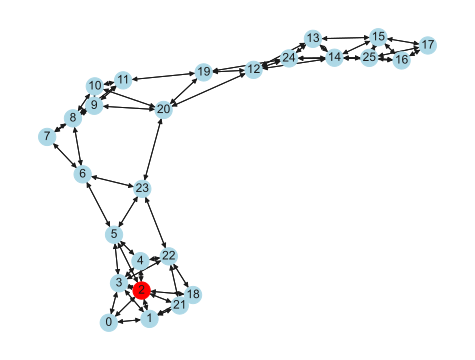

In [674]:
graph_test_1 = tu2[6]
# graph_test_1 = tu2[7] #0,6,7,16,17,19,20,25,26,30,31,32
# graph_test_1=new_subgraph(graph_test_1,add_node=[0,1,2,4,5,6,7])
draw_with_color(graph_test_1)

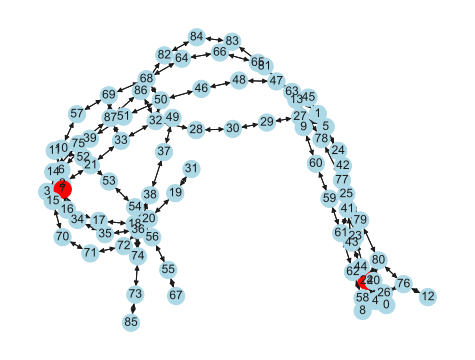

In [230]:
graph_test_1 = tu2[7]
draw_with_color(graph_test_1)

In [675]:
shapley_add_node,shapley_add_node_storage=run_shapley(graph_test_1,level=2)
# shapley_add_node

In [676]:
shapley_add_node_storage[5,4,0]

tensor(1.)

In [677]:
shapley_add_node

{'rank1': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 18: 1, 21: 1},
 'rank2': {6: 8,
  7: 8,
  8: 8,
  9: 8,
  10: 8,
  11: 8,
  12: 8,
  13: 8,
  14: 8,
  15: 8,
  16: 8,
  17: 8,
  19: 8,
  20: 8,
  22: 8,
  23: 8,
  24: 8,
  25: 8,
  1: 25,
  0: 25,
  2: 25,
  3: 25,
  4: 25,
  5: 25,
  18: 25,
  21: 25}}

In [183]:
set(list(shapley_add_node['rank1'].keys())+list(shapley_add_node['rank2'].keys()))

{0, 1, 2}

[3, 5, 7, 6, 4, 5, 4, 3, 5, 5, 4, 4, 5, 4, 6, 5, 4, 3, 4, 4, 5, 4, 5, 4, 5, 5]


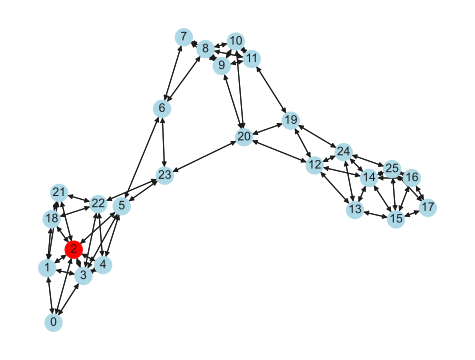

In [678]:
node_lst=list(set( val for dic in  shapley_add_node.values() for val in dic.keys()))
# seperate_1=new_subgraph(graph_test_1,list(set(list(shapley_add_node['rank1'].keys()))),draw_subgraph=True)
seperate_1=new_subgraph(graph_test_1,node_lst,draw_subgraph=True)

0
[3, 5, 7, 5, 3, 3, 3, 3]


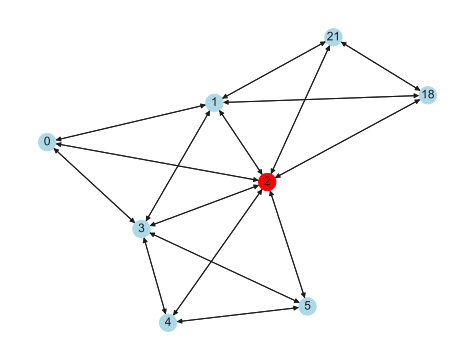

In [679]:
cut_shapley=excl_low_value_nodes(shapley_add_node['rank2'],node_threshold=seperate_1.x.shape[0]*.5)
cut_seperate_1=new_subgraph(graph_test_1,list(cut_shapley.keys()),draw_subgraph=True)

0
1


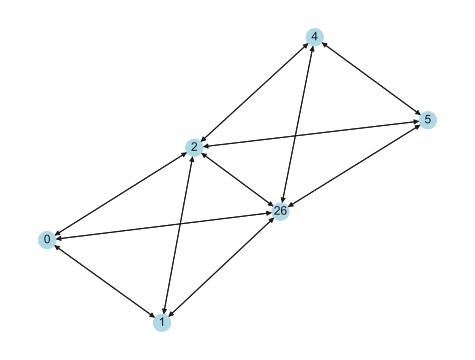

In [229]:
cut_shapley=excl_low_value_nodes(shapley_add_node['rank2'],excl_round=2,node_threshold=seperate_1.x.shape[0]*.3)
cut_seperate_1=new_subgraph(graph_test_1,list(cut_shapley.keys()),draw_subgraph=True)

In [513]:
def generate_graph(node_num,max_degree,gseed,draw_graph=False,star=False):
    np.random.seed(gseed)
    if star==True: 
        degree_lst=np.ones(max_degree+1)
        degree_lst[np.random.randint(max_degree)]=max_degree 
        print(degree_lst)
    else: 
        degree_lst=np.random.randint(max_degree-3, size=node_num)
        degree_lst[np.random.randint(node_num)]=max_degree 
    G = nx.random_degree_sequence_graph(degree_lst,gseed)
    G = from_networkx(G)
    G.x=torch.rand(node_num,1)
    if draw_graph==True: 
        draw_with_color(G)
    return G 

In [611]:
def seperate_graph(graph,node_to_excl,draw_graph=False): 
    edge_index_update=graph.edge_index
    edge_index_update=sort_edge_index(edge_index_update)
    label_max=graph.x.shape[0]
    edge_index_id=(edge_index_update == node_to_excl).nonzero()
    edge_index_copy=edge_index_update.clone()
    node_degree=int((edge_index_id.shape[0])/2)
    for i in range(node_degree): 
        edge_index_copy[0,edge_index_id[i,1]]=graph.x.shape[0]+i
        edge_index_copy[1,edge_index_id[i+node_degree,1]]=graph.x.shape[0]+i
    x_new=torch.cat((graph.x,torch.zeros(node_degree,1)))
    graph_update=Data(x=x_new, edge_index=edge_index_copy)
    if draw_graph==True: 
        draw_with_color(graph_update,extra_node=graph.x.shape[0])
    return graph_update

[1. 1. 1. 1. 7. 1. 1. 1.]


Data(edge_index=[2, 14], num_nodes=8, x=[11, 1])

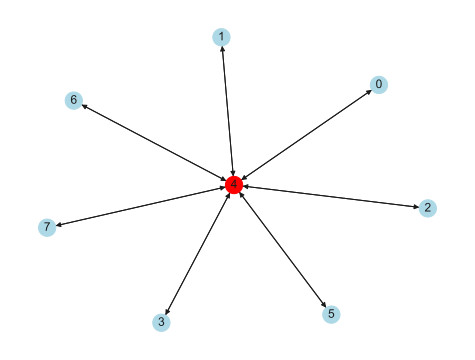

In [530]:
generate_graph(11,7,203,draw_graph=True,star=True)

[1. 1. 1. 1. 7. 1. 1. 1.]
[1, 1, 1, 1, 7, 1, 1, 1]


Data(edge_index=[2, 14], num_nodes=8, x=[8, 1])

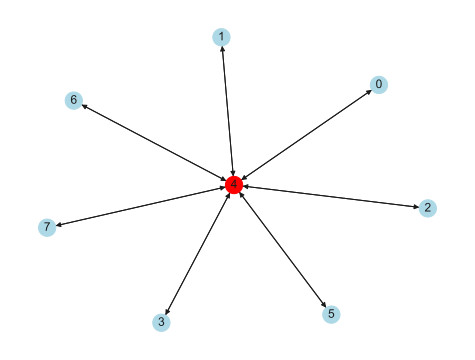

In [735]:
gg_star_1=generate_graph(8,7,203,draw_graph=True,star=True)
gg_star_1

In [738]:
calculate_shapley(gg_star_1) 

{0: 0.125,
 1: 0.125,
 2: 0.125,
 3: 0.125,
 4: 0.125,
 5: 0.125,
 6: 0.125,
 7: 0.125}

[1. 1. 1. 1. 8. 1. 1. 1. 1.]
[1, 1, 1, 1, 8, 1, 1, 1, 1]


Data(edge_index=[2, 16], num_nodes=9, x=[9, 1])

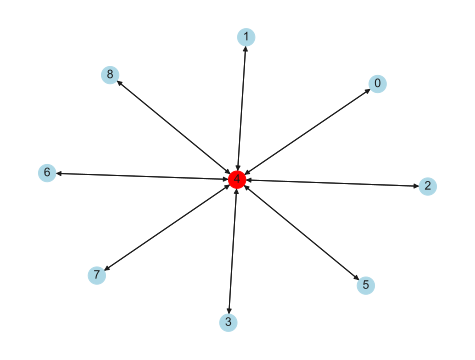

In [736]:
gg_star_2=generate_graph(9,8,203,draw_graph=True,star=True)
gg_star_2

In [737]:
calculate_shapley(gg_star_2)

{0: 0.09722222222222224,
 1: 0.09722222222222224,
 2: 0.09722222222222224,
 3: 0.09722222222222224,
 4: 0.22222222222222224,
 5: 0.09722222222222224,
 6: 0.09722222222222224,
 7: 0.09722222222222224,
 8: 0.09722222222222224}

In [726]:
gg_star_2.edge_index[0]+8

tensor([ 8,  9, 10, 11, 12, 12, 12, 12, 12, 12, 12, 13, 14, 15])

In [727]:
torch.cat((gg_star_1.x,gg_star_2.x)),gg_star_1.x,gg_star_2.x

(tensor([[0.8855],
         [0.8891],
         [0.1301],
         [0.5359],
         [0.0894],
         [0.1553],
         [0.8839],
         [0.1016],
         [0.2548],
         [0.7398],
         [0.9865],
         [0.0143],
         [0.1774],
         [0.3039],
         [0.8873],
         [0.7914]]),
 tensor([[0.8855],
         [0.8891],
         [0.1301],
         [0.5359],
         [0.0894],
         [0.1553],
         [0.8839],
         [0.1016]]),
 tensor([[0.2548],
         [0.7398],
         [0.9865],
         [0.0143],
         [0.1774],
         [0.3039],
         [0.8873],
         [0.7914]]))

[1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1]


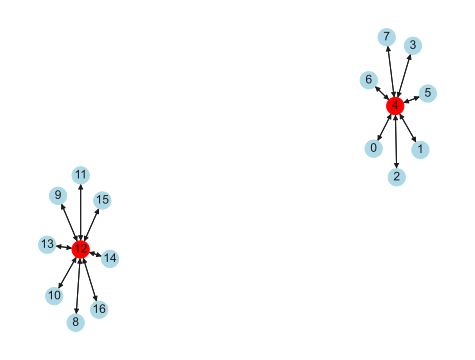

In [745]:
edge_index_new_0=torch.cat((gg_star_1.edge_index[0],gg_star_2.edge_index[0]+8))
edge_index_new_1=torch.cat((gg_star_1.edge_index[1],gg_star_2.edge_index[1]+8))
edge_index_new=torch.stack((edge_index_new_0,edge_index_new_1))
x_new=torch.cat((gg_star_1.x,gg_star_2.x))
gg_star_3 = Data(x=x_new, edge_index=edge_index_new)
draw_with_color(gg_star_3)

In [746]:
calculate_shapley(gg_star_3)

{0: 0.03676470588235283,
 1: 0.03676470588235283,
 2: 0.03676470588235283,
 3: 0.03676470588235283,
 4: 0.03676470588235283,
 5: 0.03676470588235283,
 6: 0.03676470588235283,
 7: 0.03676470588235283,
 8: 0.07148692810457499,
 9: 0.07148692810457499,
 10: 0.07148692810457499,
 11: 0.07148692810457499,
 12: 0.13398692810457488,
 13: 0.07148692810457499,
 14: 0.07148692810457499,
 15: 0.07148692810457499,
 16: 0.07148692810457499}

In [739]:
shapley_star_2,shapley_star_2_storage=run_shapley(gg_star_2,level=2)
shapley_star_2

{'rank1': {4: 1},
 'rank2': {1: 8, 0: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: 8}}

In [747]:
shapley_star_3,shapley_star_3_storage=run_shapley(gg_star_3,level=2)
shapley_star_3

No results after the 1 round


{'rank1': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 12: 8},
 'rank2': {0: 43,
  1: 43,
  2: 43,
  3: 43,
  4: 43,
  5: 43,
  6: 43,
  7: 43,
  9: 64,
  8: 64,
  10: 64,
  11: 64,
  13: 64,
  14: 64,
  15: 64,
  16: 64,
  12: 92}}

In [751]:
# shapley_star_3["rank1"]/(gg_star_3.x.shape[0])
a = {k: v / int(gg_star_2.x.shape[0])/(int(gg_star_2.x.shape[0])-1) for k, v in shapley_star_2["rank1"].items()}
a
# b = {k: v *2/ int(gg_star_2.x.shape[0])/(int(gg_star_2.x.shape[0])-1)/(int(gg_star_2.x.shape[0])-2) for k, v in shapley_star_2["rank2"].items()}
# update_value=a.copy()
# update_value=Counter(update_value)+Counter(b)
# update_value

{4: 0.013888888888888888}

In [742]:
# shapley_star_3["rank1"]/(gg_star_3.x.shape[0])
a = {k: v / int(gg_star_2.x.shape[0]) for k, v in shapley_star_2["rank1"].items()}
b = {k: v *2/ int(gg_star_2.x.shape[0])/(int(gg_star_2.x.shape[0])-1) for k, v in shapley_star_2["rank2"].items()}
update_value=a.copy()
update_value=Counter(update_value)+Counter(b)
update_value

Counter({4: 0.3333333333333333,
         1: 0.2222222222222222,
         0: 0.2222222222222222,
         2: 0.2222222222222222,
         3: 0.2222222222222222,
         5: 0.2222222222222222,
         6: 0.2222222222222222,
         7: 0.2222222222222222,
         8: 0.2222222222222222})

In [858]:
# shapley_star_3["rank1"]/(gg_star_3.x.shape[0])
a = {k: v / int(gg_star_3.x.shape[0])/(int(gg_star_3.x.shape[0])-1) for k, v in shapley_star_3["rank1"].items()}
a

{0: 0.003676470588235294,
 1: 0.003676470588235294,
 2: 0.003676470588235294,
 3: 0.003676470588235294,
 4: 0.003676470588235294,
 5: 0.003676470588235294,
 6: 0.003676470588235294,
 7: 0.003676470588235294,
 12: 0.029411764705882353}

In [859]:
a[12]-a[2]

0.025735294117647058

In [749]:
# shapley_star_3["rank1"]/(gg_star_3.x.shape[0])
b = {k: v *2/ int(gg_star_3.x.shape[0])/(int(gg_star_3.x.shape[0])-1)/(int(gg_star_3.x.shape[0])-2) for k, v in shapley_star_3["rank2"].items()}
b

{0: 0.021078431372549018,
 1: 0.021078431372549018,
 2: 0.021078431372549018,
 3: 0.021078431372549018,
 4: 0.021078431372549018,
 5: 0.021078431372549018,
 6: 0.021078431372549018,
 7: 0.021078431372549018,
 9: 0.03137254901960784,
 8: 0.03137254901960784,
 10: 0.03137254901960784,
 11: 0.03137254901960784,
 13: 0.03137254901960784,
 14: 0.03137254901960784,
 15: 0.03137254901960784,
 16: 0.03137254901960784,
 12: 0.045098039215686274}

In [717]:
from collections import Counter

In [750]:
update_value=a.copy()
update_value=Counter(update_value)+Counter(b)
update_value

Counter({0: 0.024754901960784313,
         1: 0.024754901960784313,
         2: 0.024754901960784313,
         3: 0.024754901960784313,
         4: 0.024754901960784313,
         5: 0.024754901960784313,
         6: 0.024754901960784313,
         7: 0.024754901960784313,
         12: 0.07450980392156863,
         9: 0.03137254901960784,
         8: 0.03137254901960784,
         10: 0.03137254901960784,
         11: 0.03137254901960784,
         13: 0.03137254901960784,
         14: 0.03137254901960784,
         15: 0.03137254901960784,
         16: 0.03137254901960784})

In [901]:
sum(list(update_value.values()))

0.5235294117647058

In [709]:
shapley_star_3.items()

dict_items([('rank1', {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 12: 8}), ('rank2', {0: 43, 1: 43, 2: 43, 3: 43, 4: 43, 5: 43, 6: 43, 7: 43, 9: 64, 8: 64, 10: 64, 11: 64, 13: 64, 14: 64, 15: 64, 16: 64, 12: 92})])

In [627]:
# random.seed(12)
# generate_graph(11,7,116,draw_graph=True)

[1. 1. 1. 1. 7. 1. 1. 1.]
[1, 1, 1, 1, 7, 1, 1, 1]


tensor([[0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 5, 6, 7],
        [4, 4, 4, 4, 0, 1, 2, 3, 5, 6, 7, 4, 4, 4]])

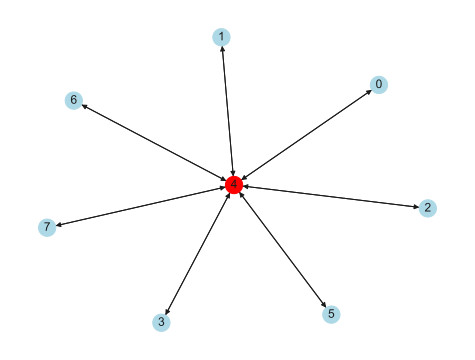

In [633]:
# gg=generate_graph(11,7,116,draw_graph=True)
gg=generate_graph(11,7,203,draw_graph=True,star=True)
edge_index_update=gg.edge_index
edge_index_update=sort_edge_index(edge_index_update)
edge_index_update

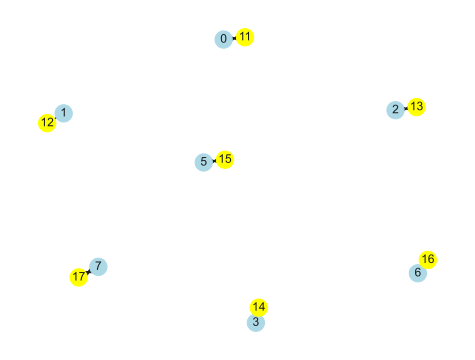

In [585]:
seperate_graph(gg,4,draw_graph=True)

In [634]:
gg.x.shape[0]

11

In [658]:
dc={}
dc[1]=0
dc[1]+=.1
dc

{1: 0.1}

In [671]:
def calculate_shapley(graph,model=model): 
    phi={}
    n=graph.x.shape[0] 
    x_lst=[i for i in range(n)]
    w={}
    for i in range(n): 
        w[i]=factorial(i)*factorial(n-i-1)/factorial(n)
    for j in range(n): 
        lst_minus_j=x_lst.copy()
        lst_minus_j.pop(j) 
        phi[j]=0
        for k in range(n): 
            if k==0: 
                graph_C_j=new_subgraph(graph,include_node_lst=[j],exclude_node_lst=None,add_sudo_nodes=False)
                v_C_j=model(graph_C_j)[2]
                phi[j]+=w[k]*int(v_C_j)
            else: 
                set_C_lst=list(itertools.combinations(lst_minus_j, k))
                for l in range(len(set_C_lst)): 
                    set_C=list(set_C_lst[l])
                    set_C_j=set_C+[j]
                    graph_C=new_subgraph(graph,include_node_lst=set_C,exclude_node_lst=None,add_sudo_nodes=False)
                    graph_C_j=new_subgraph(graph,include_node_lst=set_C_j,exclude_node_lst=None,add_sudo_nodes=False)
                    v_C=model(graph_C)[2]
                    v_C_j=model(graph_C_j)[2]
                    phi[j]+=w[k]*int(v_C_j-v_C)
    return phi 
        
    

In [ ]:
list(itertools.combinations(lst_minus_j, k))

In [672]:
calculate_shapley(gg)

{0: 0.125,
 1: 0.125,
 2: 0.125,
 3: 0.125,
 4: 0.125,
 5: 0.125,
 6: 0.125,
 7: 0.125,
 8: 0.0,
 9: 0.0,
 10: 0.0}

calculate_shapley(graph_test_1)

In [648]:
n=gg.x.shape[0]
x_lst=[i for i in range(n)]
x_lst

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [650]:
[1,2]+[4]

[1, 2, 4]

In [661]:
factorial(5)

120

In [659]:
import itertools
from math import factorial

In [647]:
print(list(itertools.combinations(x_lst, 2)))

[(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)]


In [643]:
perm_lst=list(itertools.combinations(x_lst, 2))
list(perm_lst[1])

[0, 2]

In [649]:
x_j_lst=x_lst.copy()
x_j_lst.pop(2)
x_lst,x_j_lst

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

In [656]:
graph_i=new_subgraph(gg,include_node_lst=list(perm_lst[1]),exclude_node_lst=None,add_sudo_nodes=False)
int(model(graph_i)[2]-model(gg)[2])

-1

In [532]:
sort_edge_index(edge_index_update)

tensor([[0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 5, 6, 7],
        [4, 4, 4, 4, 0, 1, 2, 3, 5, 6, 7, 4, 4, 4]])

In [533]:
gg.x.shape[0]

11

In [576]:
node_val=7
label_max=gg.x.shape[0]
edge_index_id=(edge_index_update == node_val).nonzero()
edge_index_id

tensor([[ 0, 13],
        [ 1, 10]])

In [577]:
edge_index_copy=edge_index_update.clone()
node_degree=int((edge_index_id.shape[0])/2)
print(node_degree)
for i in range(node_degree): 
    # print((0,edge_index_id[i,1]),edge_index_copy[0,edge_index_id[i,1]])
    # print((1,edge_index_id[i+node_degree,1]),edge_index_copy[1,edge_index_id[i+node_degree,1]])
    edge_index_copy[0,edge_index_id[i,1]]=gg.x.shape[0]+i
    edge_index_copy[1,edge_index_id[i+node_degree,1]]=gg.x.shape[0]+i
edge_index_copy

1


tensor([[ 0,  1,  2,  3,  4,  4,  4,  4,  4,  4,  4,  5,  6, 11],
        [ 4,  4,  4,  4,  0,  1,  2,  3,  5,  6, 11,  4,  4,  4]])

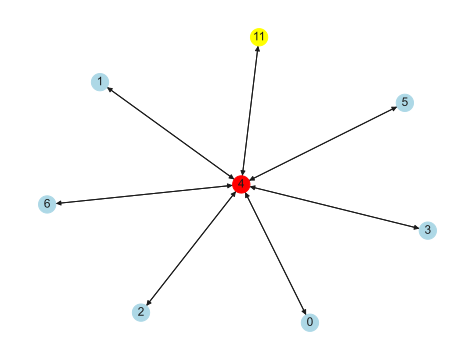

In [579]:
x_new=torch.cat((gg.x,torch.zeros(node_degree,1)))
graph_update=Data(x=x_new, edge_index=edge_index_copy)
draw_with_color(graph_update,extra_node=gg.x.shape[0])

In [581]:
model(graph_update)[2]

tensor([1.])

In [597]:
def run_shapley_mini(graph,level=1,shapley_storage=None,skip_to_round=1,previous_shapley=None,node_list=node_lst): 
    graph_label=model(graph)[2]
    node_num=len(node_list)
    n=node_num
    if shapley_storage==None: 
        shapley_storage = torch.zeros((n,n,n))
    else: 
        shapley_storage=shapley_storage
    shapley_dict={}
    round=skip_to_round
    rank=1

    if round==1:     
        shapley_dict["rank"+str(rank)]=[]
        for t in range(node_num):
            i=node_list[t]
            edge_index_update=graph.edge_index
            # print(graph)
            graph_i=seperate_graph(graph=graph,node_to_excl=i)
            # print(graph_i)
            # graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i],add_sudo_nodes=False)  
            shapley_i=graph_label-model(graph_i)[2] 
            # print(shapley_i)
            if shapley_i!=0: 
                shapley_storage[i,0,0]=1
                shapley_dict["rank"+str(rank)].append(i)
        if len(shapley_dict["rank"+str(rank)])>0: 
            shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
            if rank==level: 
                return shapley_dict,shapley_storage
            else: 
                rank+=1 
                # round+=1                       
        else: 
            print("No results after the "+str(round)+" round")
        round+=1 
        
    # if round==2: 
    #     shapley_dict["rank"+str(rank)]=[]
    #     for t in range(node_num):
    #         # print(i)
    #         for s in range(t):
    #             i=node_list[t]
    #             j=node_list[s]
    #             graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j],add_sudo_nodes=False)    
    #             shapley_i=shapley_storage[i,0,0]-model(graph_i)[2] 
    #             shapley_i=graph_label-model(graph_i)[2] 
                
    #             # if (i==5) and (j==4): 
    #             #     print(shapley_storage[i,0,0],model(graph_i)[2],shapley_i)
    #             if shapley_i!=0: 
    #                 shapley_storage[i,j,0]=1
    #                 shapley_dict["rank"+str(rank)].append(i)
    #                 shapley_dict["rank"+str(rank)].append(j)
    
    #     if len(shapley_dict["rank"+str(rank)])>0: 
    #         shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
    #         if rank==level: 
    #             return shapley_dict,shapley_storage 
    #         else: rank+=1 
    #     else: 
    #         print("No results after the "+str(round)+" round") 
    #     round+=1
            
    # if round==3: 
    #     shapley_dict["rank"+str(rank)]=[]
    #     for t in range(node_num):
    #         for s in range(i): 
    #             for w in range(j): 
    #                 i=node_list[t]
    #                 j=node_list[s]
    #                 k=node_list[w]
    #                 # graph_i=new_subgraph(graph=graph,include_node_lst=None,exclude_node_lst=[i,j,k],add_sudo_nodes=False)    
    #                 shapley_i=shapley_storage[i,j,0]-model(graph_i)[2] 
    #                 shapley_i=graph_label-model(graph_i)[2] 
    #                 # if shapley_i>0: 
    #                 if model(graph_i)[2]<1: 
    #                     shapley_storage[i,j,k]=1
    #                     shapley_dict["rank"+str(rank)].append(i)
    #                     shapley_dict["rank"+str(rank)].append(j)
    #                     shapley_dict["rank"+str(rank)].append(k)
    #     if len(shapley_dict["rank"+str(rank)])>0: 
    #         shapley_dict["rank"+str(rank)]=shapley_dict_count(shapley_dict["rank"+str(rank)])
    #         if rank==level: 
    #             return shapley_dict,shapley_storage 
    #         else: rank+=1 
    #     else: 
    #         print("No results after the "+str(round)+" round") 
    #         round+=1
    #     # return shapley_dict  , shapley_storage

In [602]:
run_shapley(gg)[0]

{'rank1': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}}

In [608]:
run_shapley_mini(gg,level=1)[0]

{'rank1': {4: 1}}

[1, 1, 1, 1, 7, 1, 1, 1]


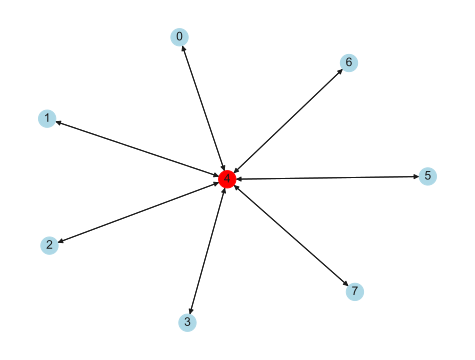

In [625]:
seperate_1=new_subgraph(gg,list(run_shapley(gg)[0]["rank1"].keys()),draw_subgraph=True)

In [265]:
from torch_geometric.utils.convert import from_networkx
sequence = [1, 2, 2, 3]
G = nx.random_degree_sequence_graph(sequence)
G = from_networkx(G)
G.x=torch.rand(4,1)
G.x

tensor([[0.2520],
        [0.7735],
        [0.8243],
        [0.4374]])

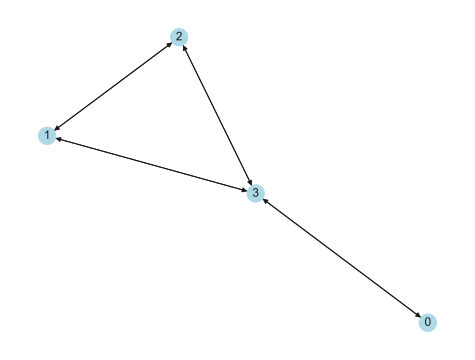

In [267]:
draw_with_color(G)

## New Algo 

In [839]:
fac_w=[]
for k in range(1,n+1): 
    fac_w.append(factorial(n-k)*factorial(k-1)/factorial(n))
fac_w

[0.038461538461538464,
 0.0015384615384615385,
 0.0001282051282051282,
 1.6722408026755853e-05,
 3.040437823046519e-06,
 7.239137673920283e-07,
 2.1717413021760849e-07,
 8.001152165911891e-08,
 3.556067629294174e-08,
 1.882624039038092e-08,
 1.1766400243988075e-08,
 8.628693512257922e-09,
 7.396023010506791e-09,
 7.396023010506791e-09,
 8.628693512257922e-09,
 1.1766400243988075e-08,
 1.882624039038092e-08,
 3.556067629294174e-08,
 8.001152165911891e-08,
 2.1717413021760849e-07,
 7.239137673920283e-07,
 3.040437823046519e-06,
 1.6722408026755853e-05,
 0.0001282051282051282,
 0.0015384615384615385,
 0.038461538461538464]

In [838]:
sum(fac_w)

0.08029814250301529

In [934]:
def partial_shapley(graph,K=None): 
    n=graph.x.shape[0]
    # print(n)
    x_lst=[i for i in range(n)]
    # print(n)
    if K==None: 
        K=n
    else: K=K 
    x_lst
    fac_w=[]
    for k in range(1,n+1): 
        fac_w.append(factorial(n-k)*factorial(k-1)/factorial(n))
    fac_w
    score_dict=dict(zip(x_lst,np.zeros(len(x_lst))))
    score_dict
    pos_G_k={}
    for k in range(K): 
        # if k==1: 
        #     pos_G_k[k-1]=list(itertools.combinations(x_lst, k))
        if k==0: 
            pos_G_k[k-1]=[]
            pos_G_k[k]=[] 
            w_k=factorial(n-k-1)*factorial(k)/factorial(n)
            for i in list(set(x_lst)): 
                # print(i)
                U_i=[i]
                graph_U_i=new_subgraph(graph,include_node_lst=list(set(x_lst)-set(U_i)),exclude_node_lst=None,add_sudo_nodes=False)
                f_U_i=model(graph_U_i)[2] 
                
                if int(f_U_i)==int(0): 
                    # print(f_U_i)
                    # score_dict[i]=score_dict[i]+w_k
                    score_dict[i]=score_dict[i]+w_k
                else: 
                    pos_G_k[k].append(U_i)
                    # print(U_i)
        else: 
            # if k==1: 
            #     print(k)
            #     print(pos_G_k[k-1])
            pos_G_k[k]=[] 
            for U in pos_G_k[k-1]:
                # print(list(U)) 
                U=list(U) 
                w_k=factorial(n-k-1)*factorial(k)/factorial(n)
                for i in list(set(x_lst)-set(U)): 
                    # print(i)
                    U_i=U+[i]
                    # graph_U_i=new_subgraph(graph,include_node_lst=list(set(x_lst)-set(U_i)),exclude_node_lst=None,add_sudo_nodes=False)
                    graph_U_i=new_subgraph(graph,include_node_lst=None,exclude_node_lst=U_i,add_sudo_nodes=False)
                    f_U_i=model(graph_U_i)[2] 
                    
                    if int(f_U_i)==int(0): 
                        # print(f_U_i)
                        # score_dict[i]=score_dict[i]+w_k
                        score_dict[i]=score_dict[i]+w_k
                    else: pos_G_k[k].append(U_i)
                
    return score_dict

[1, 1, 1, 1, 8, 1, 1, 1, 1]


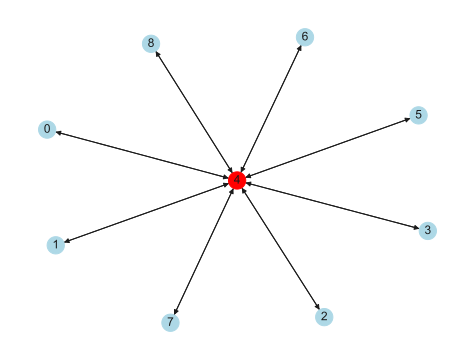

In [821]:
draw_with_color(gg_star_2)

In [916]:
partial_shapley(gg_star_2)

{0: 0.09722222222222224,
 1: 0.09722222222222224,
 2: 0.09722222222222224,
 3: 0.09722222222222224,
 4: 0.22222222222222227,
 5: 0.09722222222222224,
 6: 0.09722222222222224,
 7: 0.09722222222222224,
 8: 0.09722222222222224}

In [935]:
partial_shapley(gg_star_2,K=1)

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.1111111111111111,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0}

In [936]:
partial_shapley(gg_star_2,K=3)

{0: 0.09722222222222224,
 1: 0.09722222222222224,
 2: 0.09722222222222224,
 3: 0.09722222222222224,
 4: 0.22222222222222227,
 5: 0.09722222222222224,
 6: 0.09722222222222224,
 7: 0.09722222222222224,
 8: 0.09722222222222224}

In [907]:
sum(list(partial_shapley(gg_star_2).values()))

1.0

In [908]:
partial_shapley(gg_star_1)

{0: 0.125,
 1: 0.125,
 2: 0.125,
 3: 0.125,
 4: 0.125,
 5: 0.125,
 6: 0.125,
 7: 0.125}

In [930]:
partial_shapley(gg_star_3,K=4)

17


{0: 0.09191176470588208,
 1: 0.09191176470588208,
 2: 0.09191176470588208,
 3: 0.09191176470588208,
 4: 0.09191176470588208,
 5: 0.09191176470588208,
 6: 0.09191176470588208,
 7: 0.09191176470588208,
 8: 0.17843137254901903,
 9: 0.17843137254901903,
 10: 0.17843137254901903,
 11: 0.17843137254901903,
 12: 0.2960784313725481,
 13: 0.17843137254901903,
 14: 0.17843137254901903,
 15: 0.17843137254901903,
 16: 0.17843137254901903}

In [938]:
partial_shapley(gg_star_3,K=3)

{0: 0.038970588235294035,
 1: 0.038970588235294035,
 2: 0.038970588235294035,
 3: 0.038970588235294035,
 4: 0.038970588235294035,
 5: 0.038970588235294035,
 6: 0.038970588235294035,
 7: 0.038970588235294035,
 8: 0.054901960784313586,
 9: 0.054901960784313586,
 10: 0.054901960784313586,
 11: 0.054901960784313586,
 12: 0.11960784313725459,
 13: 0.054901960784313586,
 14: 0.054901960784313586,
 15: 0.054901960784313586,
 16: 0.054901960784313586}

In [939]:
sum(list(partial_shapley(gg_star_3,K=3).values()))

0.8705882352941154

In [940]:
partial_shapley(gg_star_3,K=4)

{0: 0.09191176470588208,
 1: 0.09191176470588208,
 2: 0.09191176470588208,
 3: 0.09191176470588208,
 4: 0.09191176470588208,
 5: 0.09191176470588208,
 6: 0.09191176470588208,
 7: 0.09191176470588208,
 8: 0.17843137254901903,
 9: 0.17843137254901903,
 10: 0.17843137254901903,
 11: 0.17843137254901903,
 12: 0.2960784313725481,
 13: 0.17843137254901903,
 14: 0.17843137254901903,
 15: 0.17843137254901903,
 16: 0.17843137254901903}

In [941]:
sum(list(partial_shapley(gg_star_3,K=4).values()))

2.4588235294117564

In [920]:
partial_shapley(gg_star_3,K=1)

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0}

In [937]:
partial_shapley(gg_star_3,K=2)

{0: 0.003676470588235294,
 1: 0.003676470588235294,
 2: 0.003676470588235294,
 3: 0.003676470588235294,
 4: 0.003676470588235294,
 5: 0.003676470588235294,
 6: 0.003676470588235294,
 7: 0.003676470588235294,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.029411764705882356,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0}

In [927]:
partial_shapley(graph_test_1,K=3)

26


{0: 0.10538461538461694,
 1: 0.10538461538461694,
 2: 0.10538461538461694,
 3: 0.10538461538461694,
 4: 0.10538461538461694,
 5: 0.10538461538461694,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.10538461538461694,
 19: 0.0,
 20: 0.0,
 21: 0.10538461538461694,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0}

In [924]:
graph_test_2 = tu2[7]
# draw_with_color(graph_test_1)
partial_shapley(graph_test_2,K=3)

KeyboardInterrupt: 

In [919]:
sum(list(partial_shapley(gg_star_3,K=6).values()))

KeyboardInterrupt: 

In [752]:
graph=graph_test_1

In [767]:
lst1=[1,2,3]
lst2=np.zeros(len(lst1))
dict(zip(lst1,lst2))

{1: 0.0, 2: 0.0, 3: 0.0}

In [797]:
n

26

In [807]:
k=1
n=graph.x.shape[0]
x_lst=[i for i in range(n)]
x_lst

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [802]:
score_dict=dict(zip(x_lst,np.zeros(len(x_lst))))
score_dict

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0}

In [803]:
pos_G_k={}
pos_G_k[k-1]=list(itertools.combinations(x_lst, k))
pos_G_k[k-1]

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,),
 (21,),
 (22,),
 (23,),
 (24,),
 (25,)]

In [804]:
int(f_U_i)

0

In [812]:
pos_G_k[k]=[]
# k=n
for U in pos_G_k[k-1]:
    # print(list(U)) 
    U=list(U) 
    w_k=factorial(n-k)*factorial(k-1)/factorial(n)
    for i in list(set(x_lst)-set(U)): 
        # print(i)
        U_i=U+[i]
        graph_U_i=new_subgraph(graph,include_node_lst=U_i,exclude_node_lst=None,add_sudo_nodes=False)
        f_U_i=model(graph_U_i)[2] 
        
        if int(f_U_i)==int(1): 
            # print(f_U_i)
            score_dict[i]=score_dict[i]+w_k
        else: pos_G_k[k].append(U_i)
pos_G_k[k]

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 14],
 [0, 15],
 [0, 16],
 [0, 17],
 [0, 18],
 [0, 19],
 [0, 20],
 [0, 21],
 [0, 22],
 [0, 23],
 [0, 24],
 [0, 25],
 [1, 0],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 9],
 [1, 10],
 [1, 11],
 [1, 12],
 [1, 13],
 [1, 14],
 [1, 15],
 [1, 16],
 [1, 17],
 [1, 18],
 [1, 19],
 [1, 20],
 [1, 21],
 [1, 22],
 [1, 23],
 [1, 24],
 [1, 25],
 [2, 0],
 [2, 1],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 9],
 [2, 10],
 [2, 11],
 [2, 12],
 [2, 13],
 [2, 14],
 [2, 15],
 [2, 16],
 [2, 17],
 [2, 18],
 [2, 19],
 [2, 20],
 [2, 21],
 [2, 22],
 [2, 23],
 [2, 24],
 [2, 25],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 9],
 [3, 10],
 [3, 11],
 [3, 12],
 [3, 13],
 [3, 14],
 [3, 15],
 [3, 16],
 [3, 17],
 [3, 18],
 [3, 19],
 [3, 20],
 [3, 21],
 [3, 22],
 [3, 23],
 [3, 24],
 [3, 25],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],


[1, 1]


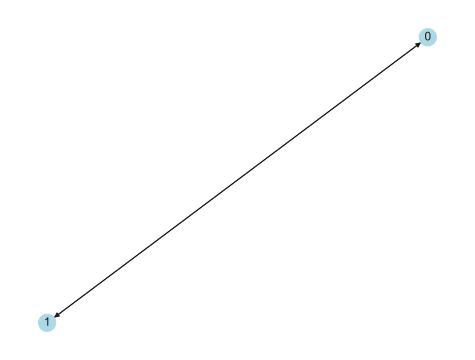

In [781]:
graph_U_i=new_subgraph(graph,include_node_lst=U_i,exclude_node_lst=None,add_sudo_nodes=False)
draw_with_color(graph_U_i)

In [772]:
score_dict

{0: 0.9615384615384611,
 1: 0.9615384615384611,
 2: 0.9615384615384611,
 3: 0.9615384615384611,
 4: 0.9615384615384611,
 5: 0.9615384615384611,
 6: 0.9615384615384611,
 7: 0.9615384615384611,
 8: 0.9615384615384611,
 9: 0.9615384615384611,
 10: 0.9615384615384611,
 11: 0.9615384615384611,
 12: 0.9615384615384611,
 13: 0.9615384615384611,
 14: 0.9615384615384611,
 15: 0.9615384615384611,
 16: 0.9615384615384611,
 17: 0.9615384615384611,
 18: 0.9615384615384611,
 19: 0.9615384615384611,
 20: 0.9615384615384611,
 21: 0.9615384615384611,
 22: 0.9615384615384611,
 23: 0.9615384615384611,
 24: 0.9615384615384611,
 25: 0.9615384615384611}

In [ ]:
torch.randint(3, 5, (3,))

In [753]:
graph_test_1

Data(edge_index=[2, 118], x=[26, 1], y=[1])

In [116]:
seperate_1

Data(x=[26, 1], edge_index=[2, 32], y=[1])

In [ ]:
run_shapley_specify(seperate_1[0],spec_node=list(seperate_1[1].keys()))

In [ ]:
def backward_rank(graph,levels=2): 
    shapley_dict["rank"+str(levels)]=shapley_dict["rank1"]
    shapley_dict["rank1"]=[]
    # graph_with_sudo = new_subgraph(graph=graph,exclude_node_lst=[0],add_sudo_nodes=True)
    for i in shapley_dict["rank"+str(levels)]:
        graph_i = new_subgraph(graph=graph,exclude_node_lst=[i],add_sudo_nodes=True)
    # global round
        # subset = torch.ones_like(graph_with_sudo.edge_index[0], dtype = bool)
        # subset[[i]] = False
        # # print(subset)
        # # graph_i=torch_geometric.utils.subgraph(subset,graph_test_1.edge_index)
        # graph_i = torch_geometric.data.Data(x=th_delete(graph_with_sudo.x,[i]),
        #                                     edge_index=torch_geometric.utils.subgraph(subset,graph_with_sudo.edge_index,relabel_nodes=True)[0],
        #                                     y=graph_with_sudo.y)
        shapley_i=model(graph_i)[2] 
        # print(shapley_i)
        if shapley_i>0: 
            print(i)
            shapley_storage[i,:,:,:,:]=1
            shapley_dict["rank"+str(levels-1)].append(i)
        if levels<=1:  
            break 
        else: level=levels-1 
shapley_dict

## Conclusion

In this tutorial, we have seen the application of neural networks to graph structures. We looked at how a graph can be represented (adjacency matrix or edge list), and discussed the implementation of common graph layers: GCN and GAT. The implementations showed the practical side of the layers, which is often easier than the theory. Finally, we experimented with different tasks, on node-, edge- and graph-level. Overall, we have seen that including graph information in the predictions can be crucial for achieving high performance. There are a lot of applications that benefit from GNNs, and the importance of these networks will likely increase over the next years.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---